In [331]:
%load_ext autoreload
%autoreload 2
from collections import defaultdict
import copy, math, sys
import numpy as np
from collections import namedtuple
import copy
import sys
sys.path.append("..")
from misc.config import *
log = main_logger
import time, random
from models.strategy import *
from models.utils import ObstructedY

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [332]:
from functools import partial

In [3]:
import recordtype
from sklearn.cluster import KMeans
from sklearn.linear_model import Perceptron

In [4]:
from models.uct import UCT, cross_and_circle, ucb_policy, eps_greedy_policy, UCTGame

[autoreload of models.strategy failed: Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
  File "../models/strategy.py", line 83
    from scikit.
               ^
SyntaxError: invalid syntax
]


In [9]:
def gauss_sample(N, K, D=2):
    mean = np.random.uniform(-10,10, size=(N,D))
    dev = np.random.uniform(0.1, 2, size=(N,))
    size = np.random.uniform(0.5*K, 1.5*K, size=(N,))
    X = []
    for m,d,s in zip(mean, dev,size):
        X.append(np.random.normal(m, d, size=(K,D)))
    return np.vstack(X)
X = gauss_sample(5, 100, 2)
m = KMeans(n_clusters=10).fit_predict(X)

hyperplane = np.random.uniform(0,1,size=(3,))
cls = np.array([hyperplane[0:2].dot(p.reshape(-1,1)) + hyperplane[2] >= 0 for p in X]).reshape(-1)

# Perceptron believes
samples = np.random.choice(range(X.shape[0]), 100)
perceptron = Perceptron().fit(X[samples], cls[samples])

cls_obstructed = ObstructedY(cls)
cls_obstructed.query(samples)

array([False,  True,  True, False,  True,  True, False,  True,  True,
        True,  True, False,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True, False, False,  True,  True,  True,
        True, False, False,  True,  True, False, False,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
       False,  True,  True,  True,  True, False,  True,  True, False,
        True,  True,  True,  True, False, False,  True, False, False,
       False, False,  True, False,  True, False,  True,  True,  True,
        True, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True, False,  True, False,
        True, False,  True, False,  True,  True,  True,  True,  True,  True], dtype=bool)

[0 1 2 3 4 5 6 7 8 9]


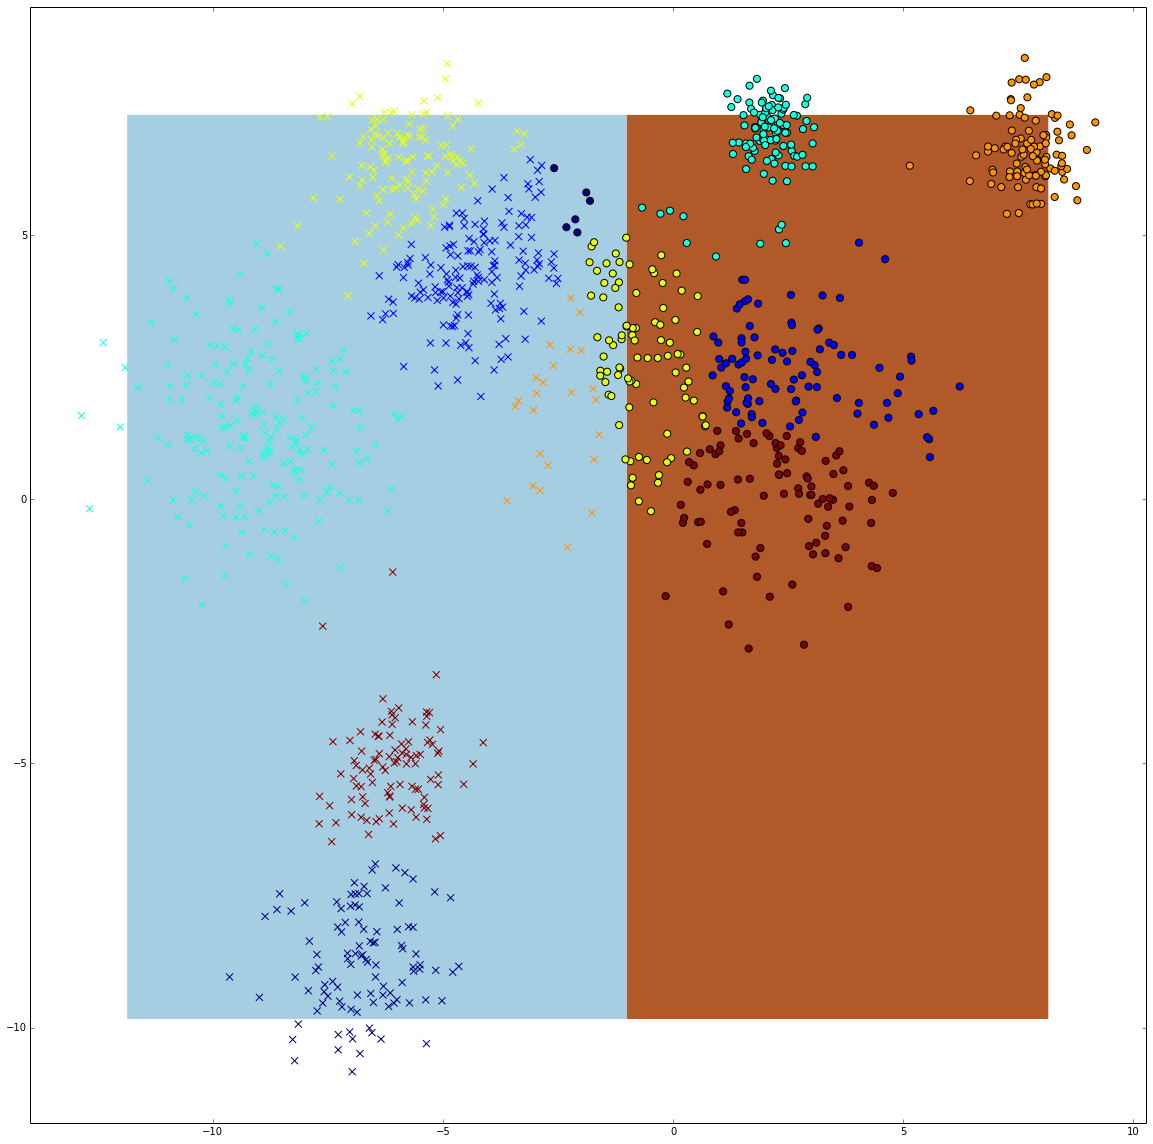

In [82]:
m = KMeans(n_clusters=10).fit_predict(X)
model = perceptron 

import matplotlib.pylab as plt
print np.unique(m)
%matplotlib inline
plt.figure(figsize=(20,20))


h = 0.1
# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = X[:, 0].min() + 1, X[:, 0].max() - 1
y_min, y_max = X[:, 1].min() + 1, X[:, 1].max() - 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')


# True examples
for mark,y in zip(['x','o'], [0,1]):
    plt.scatter(X[cls==y,0], X[cls==y,1],s=50,c = m[cls==y], marker=mark)
    
    


In [125]:
def construct_quasi_greedy_utility_fnc(X, y, c, current_model, dist):
    if isinstance(dist, str):
        dist = globals()[distance_fnc]
    
    X = X.astype("float32")
    
    _, base_scores = uncertanity_sampling(X, y, current_model, 20, 777)
    
    
    # Distance metric
    D = np.zeros(shape=(y.unknown_ids.shape[0], y.unknown_ids.shape[0]))
    for i, X_i in enumerate(y.unknown_ids):
        for j, X_j in enumerate(y.unknown_ids):
            if i>j:
                D[i,j] = dist(X[X_i], X[X_j])
                
    # Symmetrize
    for i, X_i in enumerate(y.unknown_ids):
        for j, X_j in enumerate(y.unknown_ids):
            if j<i:
                D[j,i] = D[i,j]
    
    # Just to refer properply to returned indices by uncertanity_sampling
    to_unknown_id = {v:k for k,v in enumerate(y.unknown_ids)}
    def utility(state):
        ids_to_unknown = [to_unknown_id[i] for i in state["ids"]]
        
        all_pairs_x, all_pairs_y = zip(*product(ids_to_unknown, ids_to_unknown))
        

        all_pairs = (len(state["ids"]) * (len(state["ids"])-1)) / 2.0
        value = (1.-c)*base_scores[ids_to_unknown].mean() + \
                (c/all_pairs)*D[all_pairs_x, all_pairs_y].sum()/2.0 
        # This is to comply with UCT code 
        return [-value] 
    
    return utility

def construct_quasi_greedy_get_action_fnc(X, y, current_model, n_clusters):
    X_unknown = X[y.unknown_ids]
    
    m = KMeans(n_clusters=n_clusters).fit_predict(X_unknown)
    # Construct clusters
    clusters = [list([i for i in range(X_unknown.shape[0]) if m[i] == j]) for j in range(n_clusters)]
    
    _, base_scores = uncertanity_sampling(X, y, current_model, 20, 777)
    to_unknown_id = {v:k for k,v in enumerate(y.unknown_ids)}
    
    clusters_uncertanity_score = [[base_scores[i] for i in cl] for cl in clusters]
    
    def get_action(state):
        remaining_cluster_ids = [i for i in range(n_clusters) if i not in state["cluster_ids"]]
        # Just pick biggest uncertanity from each cluster
        return zip([y.unknown_ids[clusters[i][np.argmax(clusters_uncertanity_score[i])]] \
                    for i in remaining_cluster_ids], remaining_cluster_ids)    
    return get_action, clusters

In [185]:
get_action, clusters = construct_quasi_greedy_get_action_fnc(X,cls_obstructed,  perceptron, 50)
action = get_action(state)[4]
to_unknown_id[action[0]]
to_unknown_id = {v:k for k,v in enumerate(cls_obstructed.unknown_ids)}
_, base_scores = uncertanity_sampling(X, cls_obstructed, perceptron, 20, 777)
print clusters[action[1]]
print to_unknown_id[action[0]]
print [base_scores[i] for i in clusters[action[1]]]

[335, 336, 340, 353, 383, 403, 405]
353
[0.10173103228082585, 0.099267681715437844, 0.072154080399139148, 0.14453193631002742, 0.044080432788507221, 0.064551467031177215, 0.01413207346188949]


In [117]:
get_action, clusters = construct_quasi_greedy_get_action_fnc(X,cls_obstructed,  perceptron, 50)
state = {"ids":[None],  "cluster_ids": set([2,3,4])}
actions = get_action(state)
assert(len(actions) == 50 - 3)

In [89]:
# Game definition of utility is same as strategy

utility = construct_quasi_greedy_utility_fnc(X, cls_obstructed, 0.3, perceptron, cosine_distance_normalized)

ids_quasi, fitness_quasi = quasi_greedy_batch(X, cls_obstructed, perceptron, 20, 777, \
                   base_strategy="uncertanity_sampling", dist="cosine_distance_normalized")
val = -utility({"ids": ids_quasi})[0]

assert(abs(val - fitness_quasi) < 1e-2)

2015-06-04 16:43:11,835 - al_ecml2015 - DEBUG - quasi greedy batch is picking 1 th example from 520
2015-06-04 16:43:11,881 - al_ecml2015 - DEBUG - quasi greedy batch is picking 2 th example from 520
2015-06-04 16:43:11,959 - al_ecml2015 - DEBUG - quasi greedy batch is picking 3 th example from 520
2015-06-04 16:43:12,043 - al_ecml2015 - DEBUG - quasi greedy batch is picking 4 th example from 520
2015-06-04 16:43:12,160 - al_ecml2015 - DEBUG - quasi greedy batch is picking 5 th example from 520
2015-06-04 16:43:12,272 - al_ecml2015 - DEBUG - quasi greedy batch is picking 6 th example from 520
2015-06-04 16:43:12,390 - al_ecml2015 - DEBUG - quasi greedy batch is picking 7 th example from 520
2015-06-04 16:43:12,550 - al_ecml2015 - DEBUG - quasi greedy batch is picking 8 th example from 520
2015-06-04 16:43:12,717 - al_ecml2015 - DEBUG - quasi greedy batch is picking 9 th example from 520
2015-06-04 16:43:12,875 - al_ecml2015 - DEBUG - quasi greedy batch is picking 10 th example from 520

0.631813031068
1.84021766681


In [72]:
def gauss_sample(N, K, D=2):
    mean = np.random.uniform(-10,10, size=(N,D))
    dev = np.random.uniform(0.1, 2, size=(N,))
    size = np.random.uniform(0.5*K, 1.5*K, size=(N,))
    X = []
    for m,d,s in zip(mean, dev,size):
        X.append(np.random.normal(m, d, size=(K,D)))
    return np.vstack(X)

X = gauss_sample(9, 20, 2)
hyperplane = np.random.uniform(0,1,size=(3,))
cls = np.array([hyperplane[0:2].dot(p.reshape(-1,1)) + hyperplane[2] >= 0 for p in X]).reshape(-1)
euclidean_metric = construct_normalized_euc(X)

# Perceptron believes
samples = np.random.choice(range(X.shape[0]), 100)
perceptron = Perceptron().fit(X[samples], cls[samples])

cls_obstructed = ObstructedY(cls)
cls_obstructed.query(samples)


In [345]:
set([1,2]).difference([1,2,3])

set()

In [352]:
def construct_quasi_greedy_utility_fnc(X, y, c, current_model, dist):
    if isinstance(dist, str):
        dist = globals()[distance_fnc]
    
    X = X.astype("float32")
    
    _, base_scores = uncertanity_sampling(X, y, current_model, 20, 777)
    
    
    # Distance metric
    D = np.zeros(shape=(y.unknown_ids.shape[0], y.unknown_ids.shape[0]))
    for i, X_i in enumerate(y.unknown_ids):
        for j, X_j in enumerate(y.unknown_ids):
            if i>j:
                D[i,j] = dist(X[X_i], X[X_j])
                
    # Symmetrize
    for i, X_i in enumerate(y.unknown_ids):
        for j, X_j in enumerate(y.unknown_ids):
            if j<i:
                D[j,i] = D[i,j]
    
    # Just to refer properply to returned indices by uncertanity_sampling
    to_unknown_id = {v:k for k,v in enumerate(y.unknown_ids)}
    def utility(state):
        ids_to_unknown = [to_unknown_id[i] for i in state["ids"]]
        
        all_pairs_x, all_pairs_y = zip(*product(ids_to_unknown, ids_to_unknown))
        

        all_pairs = (len(state["ids"]) * (len(state["ids"])-1)) / 2.0
        value = (1.-c)*base_scores[ids_to_unknown].mean() + \
                (c/all_pairs)*D[all_pairs_x, all_pairs_y].sum()/2.0 
        # This is to comply with UCT code 
        return [-value] 
    
    return utility

def construct_quasi_greedy_get_action_fnc(X, y, current_model, n_clusters):
    X_unknown = X[y.unknown_ids]
    
    m = KMeans(n_clusters=n_clusters).fit_predict(X_unknown)
    # Construct clusters
    clusters = [list([i for i in range(X_unknown.shape[0]) if m[i] == j]) for j in range(n_clusters)]
    
    _, base_scores = uncertanity_sampling(X, y, current_model, 20, 777)
    to_unknown_id = {v:k for k,v in enumerate(y.unknown_ids)}
    
    clusters_uncertanity_score = [[base_scores[i] for i in cl] for cl in clusters]
    
    # TODO: Kolejnosc!?!?
    def get_action(state):
        remaining_cluster_ids = [i for i in range(n_clusters) if i not in state["cluster_ids"]]
        # Just pick biggest uncertanity from each cluster
        return zip([y.unknown_ids[clusters[i][np.argmax(clusters_uncertanity_score[i])]] \
                    for i in remaining_cluster_ids], remaining_cluster_ids)    
    return get_action, clusters

def construct_quasi_greedy_get_action_fnc_pointwise(X, y, current_model, n_clusters):
    
    unknown_ids_set = set(y.unknown_ids)
    def get_actions(state):
        left_examples = copy.copy(unknown_ids_set)
        
        left_examples = left_examples.difference(state["ids"])
        left_examples = list(left_examples)
        random.shuffle(left_examples)

        return zip(left_examples, left_examples)
    
    return get_actions, None

n_clusters = 20
batch_size = 10
C = 0.4

get_actions_pointwise, _ = construct_quasi_greedy_get_action_fnc_pointwise(X, cls_obstructed, perceptron, n_clusters)
utility = construct_quasi_greedy_utility_fnc(X, cls_obstructed, C, perceptron, euclidean_metric)


def transition(state, action):
    state = copy.deepcopy(state)
    # Action is a tuple
    state["ids"].add(action[0])
    state["cluster_ids"].add(action[1]) 
    return state

def is_terminal(state, batch_size):
    return len(state["ids"]) == batch_size

def repr(state):
    return str(list(zip(state["ids"], state["cluster_ids"])))

def state_key(state):
    return str(state['ids'])

def playout_randomly(state, rng, batch_size):
    state = copy.deepcopy(state)
    actions = get_actions(state)
    random.shuffle(actions)
    for a in actions:
        # TODO: improve performance
        state = transition(state, a)
        if is_terminal(state, batch_size):
            break
    return state

#TODO: add rng
def construct_playout_distortion_greedy(batch_size, X, y, current_model, base_strategy, \
                              dist):
    D = pairwise_distances(X, metric=dist)
    def playout_randomly_dist(state, rng, y):    
        state = copy.deepcopy(state)
        y = copy.deepcopy(y)
        y.query(list(state["ids"]))
        ids, _ = quasi_greedy_batch(X, y, current_model, batch_size=batch_size - len(state["ids"]),\
                                   base_strategy=base_strategy, dist=dist, D=D)
        state["ids"] = state["ids"].union(set(ids))
        return state
    
    return partial(playout_randomly_dist, y=y)

def playout_greedy(state, rng, batch_size, X, y, current_model):
    state = copy.deepcopy(state)
    y = copy.deepcopy(y)
    y.query(list(state["ids"]))
    ids, _ = uncertanity_sampling(X, y, seed=777, current_model=current_model, batch_size=batch_size - len(state["ids"]))
    print ids
    state["ids"] = state["ids"].union(set(ids))
    return state

# Constructing game

active_learning_game_pointwise = UCTGame(get_actions=get_actions_pointwise, transition=transition,
                               is_terminal=partial(is_terminal, batch_size=batch_size), repr=repr, 
                                state_key=state_key, 
                               playout_randomly=partial(playout_randomly, batch_size=batch_size), \
                               utility=utility)

active_learning_game_playout_dist = UCTGame(get_actions=get_actions_pointwise, transition=transition,
                               is_terminal=partial(is_terminal, batch_size=batch_size), repr=repr, state_key=state_key, 
                               playout_randomly=
                                            construct_playout_distortion_greedy(
                              batch_size=batch_size, X=X, y=cls_obstructed, current_model=perceptron, \
                              base_strategy=uncertanity_sampling, \
                              dist=euclidean_metric),
                                utility=utility)

In [358]:
ids_quasi, fitness_quasi = quasi_greedy_batch(X, cls_obstructed, perceptron, batch_size, 777, \
                   base_strategy="uncertanity_sampling", c=C, dist=euclidean_metric)
print fitness_quasi

0.726102724672


In [360]:
print active_learning_game_playout_dist.utility(active_learning_game_playout_dist.playout_randomly({"ids": set([]), "cluster_ids": set([]), "player": 0}, None))

[-0.72482721122371097]


In [353]:
state = {"ids": set([]), "cluster_ids": set([]), "player": 0}
uct = UCT(N=1000, policy=ucb_policy, progressive_widening=True)
uct.fit(active_learning_game_playout_dist, state)
state = uct.best_path[-1].state

In [356]:
utility(active_learning_game_playout_dist.playout_randomly(state, None))

[-0.6666202761730935]

In [361]:
state = {"ids": set([]), "cluster_ids": set([]), "player": 0}
for i in range(batch_size):
    uct = UCT(N=1000, policy=ucb_policy, progressive_widening=True)
    uct.fit(active_learning_game_playout_dist, state)
    state = transition(state, uct.best_action)
    print state
    
print utility(state)

{'player': 0, 'cluster_ids': set([50]), 'ids': set([50])}
{'player': 0, 'cluster_ids': set([50, 28]), 'ids': set([50, 28])}
{'player': 0, 'cluster_ids': set([50, 28, 45]), 'ids': set([50, 28, 45])}
{'player': 0, 'cluster_ids': set([41, 50, 28, 45]), 'ids': set([41, 50, 28, 45])}
{'player': 0, 'cluster_ids': set([41, 50, 51, 28, 45]), 'ids': set([41, 50, 51, 28, 45])}
{'player': 0, 'cluster_ids': set([41, 45, 49, 50, 51, 28]), 'ids': set([41, 45, 49, 50, 51, 28])}
{'player': 0, 'cluster_ids': set([37, 41, 45, 49, 50, 51, 28]), 'ids': set([37, 41, 45, 49, 50, 51, 28])}
{'player': 0, 'cluster_ids': set([37, 41, 45, 109, 49, 50, 51, 28]), 'ids': set([37, 41, 45, 109, 49, 50, 51, 28])}
{'player': 0, 'cluster_ids': set([37, 41, 109, 45, 49, 50, 51, 24, 28]), 'ids': set([37, 41, 109, 45, 49, 50, 51, 24, 28])}
{'player': 0, 'cluster_ids': set([37, 41, 45, 109, 49, 50, 51, 87, 24, 28]), 'ids': set([37, 41, 45, 109, 49, 50, 51, 87, 24, 28])}
[-0.65723993195082964]


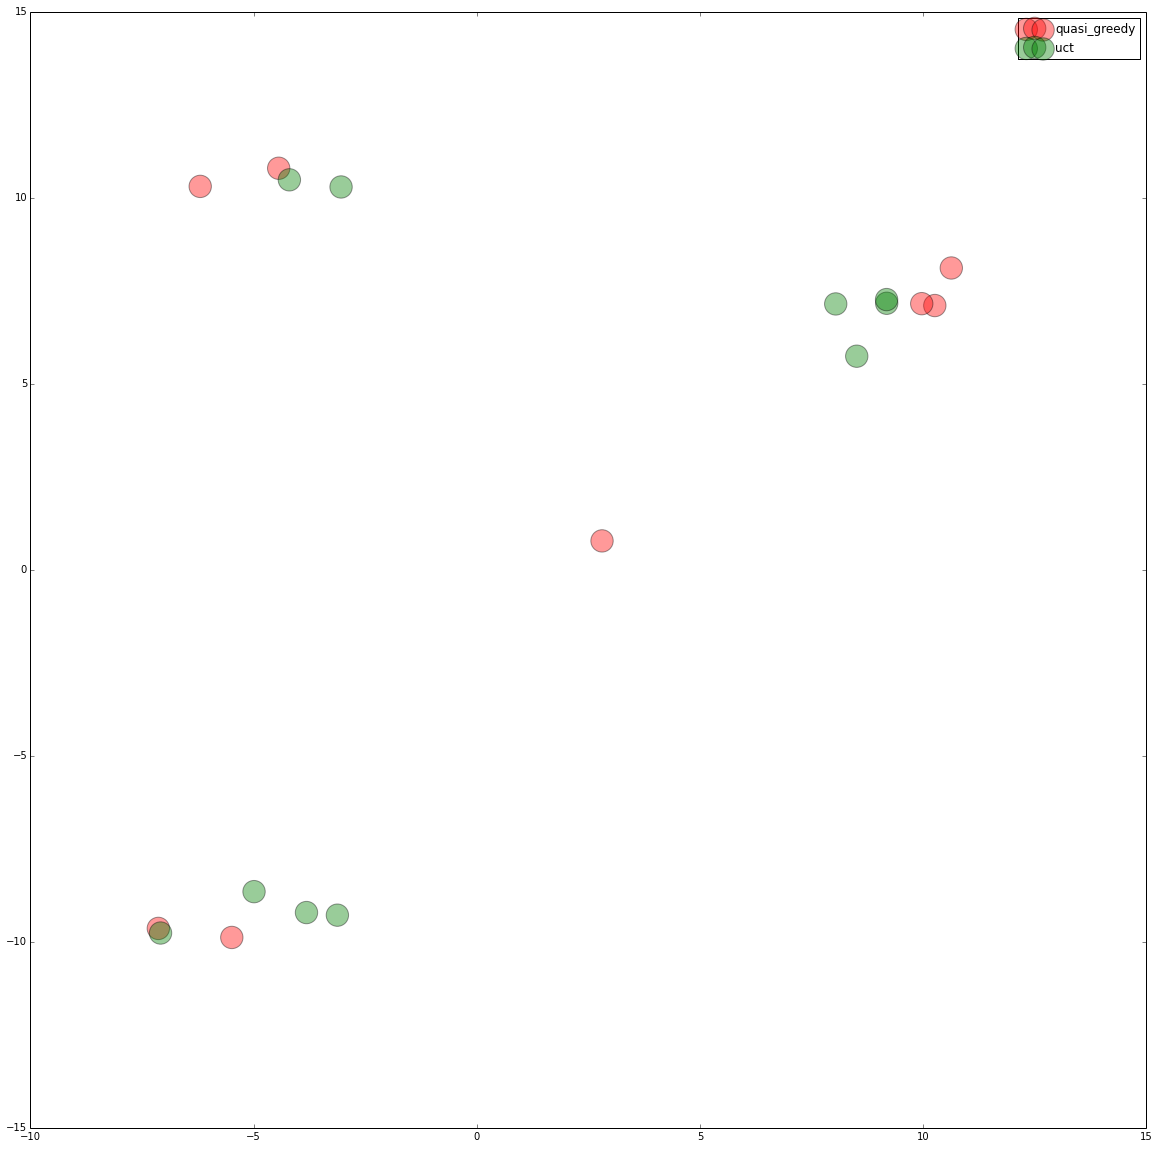

In [199]:
# True examples
import matplotlib.pylab as plt
%matplotlib inline

plt.figure(figsize=(20,20))
c = np.array([1 for _ in range(X.shape[0])])
c[ids_quasi] = 2
c[list(state["ids"])] = 5


plt.scatter(X[c==2,0], X[c==2,1], alpha=0.4, s=500, c="r", label="quasi_greedy")
plt.scatter(X[c==5,0], X[c==5,1], alpha=0.4, s=500, c="g",  label="uct")
plt.legend()
    